In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
# for circuit construction
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
# QFT circuit needed for phase estimation
from qiskit.circuit.library import QFT
# for creating custom gates
from qiskit import quantum_info as qi
# for simulation
from qiskit_aer import Aer
from qiskit import transpile
from qiskit.visualization import plot_histogram
# for storing data later
import pandas as pd

In [2]:
#4-city graph edge weights as described in chapter 4.1
w_1 = 4 # a <-> b
w_2 = 2 # a <-> c
w_3 = 4 # a <-> d
w_4 = 4 # b <-> c
w_5 = 5 # c <-> d
w_6 = 6 # b <-> d
weights = []
for i in range(1, 7):
    variable_name = "w_" + str(i)
    current_number = locals()[variable_name]
    weights.append(current_number)
#sorting edge weights
sorted_weights = np.sort(weights)[::-1]
# normalization factor
S = np.sum(sorted_weights[:4])
# epsilon
eps = 1
weights = weights / (S + eps)
weights

array([0.2 , 0.1 , 0.2 , 0.2 , 0.25, 0.3 ])

In [3]:
## solutions
# A->B->C->D->A
# A->B->D->C->A
# A->C->B->D->A
print('solution 1: {:.2f}'.format(weights[0] + weights[3] + weights[4] + weights[2]))
print('solution 2: {}'.format(weights[0] + weights[5] + weights[4] + weights[1]))
print('solution 3: {}'.format(weights[1] + weights[3] + weights[5] + weights[2]))
print(" ")
print('solutions after max weight removed')
print('solution 1: {:.2f}'.format(weights[0] + weights[3] + weights[4] + weights[2]))
print('solution 2: {}'.format(weights[0] + weights[4] + weights[1]))
print('solution 3: {}'.format(weights[1] + weights[3] + weights[2]))

solution 1: 0.85
solution 2: 0.85
solution 3: 0.8
 
solutions after max weight removed
solution 1: 0.85
solution 2: 0.55
solution 3: 0.5


In [4]:
## Creating CU matrix
m = 8 # eigenvalue qubits
U111 = 1
U122 = np.exp(1j * weights[0] * 2 * np.pi)
U133 = np.exp(1j * weights[1] * 2 * np.pi)
U144 = np.exp(1j * weights[2] * 2 * np.pi)
U1 = np.diag([U111, U122, U133, U144])
U211 = np.exp(1j * weights[0] * 2 * np.pi)
U222 = 1
U233 = np.exp(1j * weights[3] * 2 * np.pi)
U244 = np.exp(1j * weights[5] * 2 * np.pi)
U2 = np.diag([U211, U222, U233, U244])
U311 = np.exp(1j * weights[1] * 2 * np.pi)
U322 = np.exp(1j * weights[3] * 2 * np.pi)
U333 = 1
U344 = np.exp(1j * weights[4] * 2 * np.pi)
U3 = np.diag([U311, U322, U333, U344])
U411 = np.exp(1j * weights[2] * 2 * np.pi)
U422 = np.exp(1j * weights[5] * 2 * np.pi)
U433 = np.exp(1j * weights[4] * 2 * np.pi)
U444 = 1
U4 = np.diag([U411, U422, U433, U444])
U = np.kron(np.kron(np.kron(U1,U2),U3),U4)
print(np.all(np.diag(U) != 0)) # confirming only the diagonal is being used.
Ugate = qi.Operator(U).to_instruction()
Ugate.label = "CU"
CUgate = Ugate.control()

True


In [5]:
## confirming the eigenstates are correct
eigstatelist = ['01101100', #1230 A->B->C->D->A
'01110010', #1302 A->B->D->C->A
'10110100'] #2310 A->C->B->D->A
U_angles = np.diag(np.angle(U))/2/np.pi
eiglistint = [int(eigstatelist[i], 2) for i in range(len(eigstatelist))]
# converting from (-pi,pi) to (0,2pi)
sol_check = U_angles[eiglistint] + 1
sol_check

array([0.85, 0.85, 0.8 ])

In [6]:
### creating CU'
## removing edge-weight value 6 (normalized val = 0.3)
max_index = np.where(weights == 0.3)[0][0]
weights[max_index] = 0
U111 = 1
U122 = np.exp(1j * weights[0] * 2 * np.pi)
U133 = np.exp(1j * weights[1] * 2 * np.pi)
U144 = np.exp(1j * weights[2] * 2 * np.pi)
U1 = np.diag([U111, U122, U133, U144])
U211 = np.exp(1j * weights[0] * 2 * np.pi)
U222 = 1
U233 = np.exp(1j * weights[3] * 2 * np.pi)
U244 = np.exp(1j * weights[5] * 2 * np.pi)
U2 = np.diag([U211, U222, U233, U244])
U311 = np.exp(1j * weights[1] * 2 * np.pi)
U322 = np.exp(1j * weights[3] * 2 * np.pi)
U333 = 1
U344 = np.exp(1j * weights[4] * 2 * np.pi)
U3 = np.diag([U311, U322, U333, U344])
U411 = np.exp(1j * weights[2] * 2 * np.pi)
U422 = np.exp(1j * weights[5] * 2 * np.pi)
U433 = np.exp(1j * weights[4] * 2 * np.pi)
U444 = 1
U4 = np.diag([U411, U422, U433, U444])
Up = np.kron(np.kron(np.kron(U1,U2),U3),U4)
print(np.all(np.diag(Up) != 0))# confirming only the diagonal is being used.
UPgate = qi.Operator(Up).to_instruction()
UPgate.label = "CU'"
CUPgate = UPgate.control()

True


In [7]:
U_angles = np.diag(np.angle(Up))/2/np.pi
eiglistint = [int(eigstatelist[i], 2) for i in range(len(eigstatelist))]
# converting from (-pi,pi) to (0,2pi)
sol_check = U_angles[eiglistint] + 1
sol_check[2] -= 1
sol_check

array([0.85, 0.55, 0.5 ])

In [8]:
def bitstring_converter(string):

    '''
    converts binary values < 1 to decimal
    specifically for the results retrieved
    from simulation
    '''
    values = []
    value = 0
    j = 0
    for i, v in enumerate(string):
        if v == '1':
            value += 1/(2**(i+1-j))
        elif v == " ":
            values.append(value)
            value = 0
            j = i+1
        if i == len(string)-1:
            values.append(value)
    return values[::-1]

def SingleHamiltonianCycle(eig, n):
    # we need a register for the eigenstate:
    eigst = QuantumRegister(m, name = 'eigenstate')
    # we need two registers for the constrained problem:
    phase = QuantumRegister(n, name = 'phase')
    phase_c = QuantumRegister(n, name = 'phase c')
    cr = ClassicalRegister(n, 'output')
    cr_c = ClassicalRegister(n, 'output c')
    # constructing the circuit (Initialization):
    qc = QuantumCircuit(phase, phase_c,eigst, cr,cr_c)
    # Apply H-Gates to phase qubits:
    for qubit in range(2*n):
        qc.h(qubit)
    for ind, val in enumerate(eig):
        if(int(val)):
            qc.x(ind + 2*n)
    ## Phase Estimation
    eig_qubits = np.arange(0,m) + 2*n
    repetitions = 1
    for counting_qubit in range(2*n):
        if counting_qubit == n:
            repetitions = 1
            qc.append(QFT(num_qubits = n, inverse = True, do_swaps=True), phase)
            qc.barrier()
        applied_qubits = np.append([counting_qubit], [eig_qubits])
        for i in range(repetitions):
            if counting_qubit < n:
                qc.append(CUgate, list(applied_qubits)); # This is CU
            else:
                qc.append(CUPgate, list(applied_qubits));
        repetitions *= 2
    qc.append(QFT(num_qubits = n, inverse = True, do_swaps=True), phase_c)
    qc.barrier()
    qc.measure(phase,cr)
    qc.measure(phase_c,cr_c)
    
    return qc

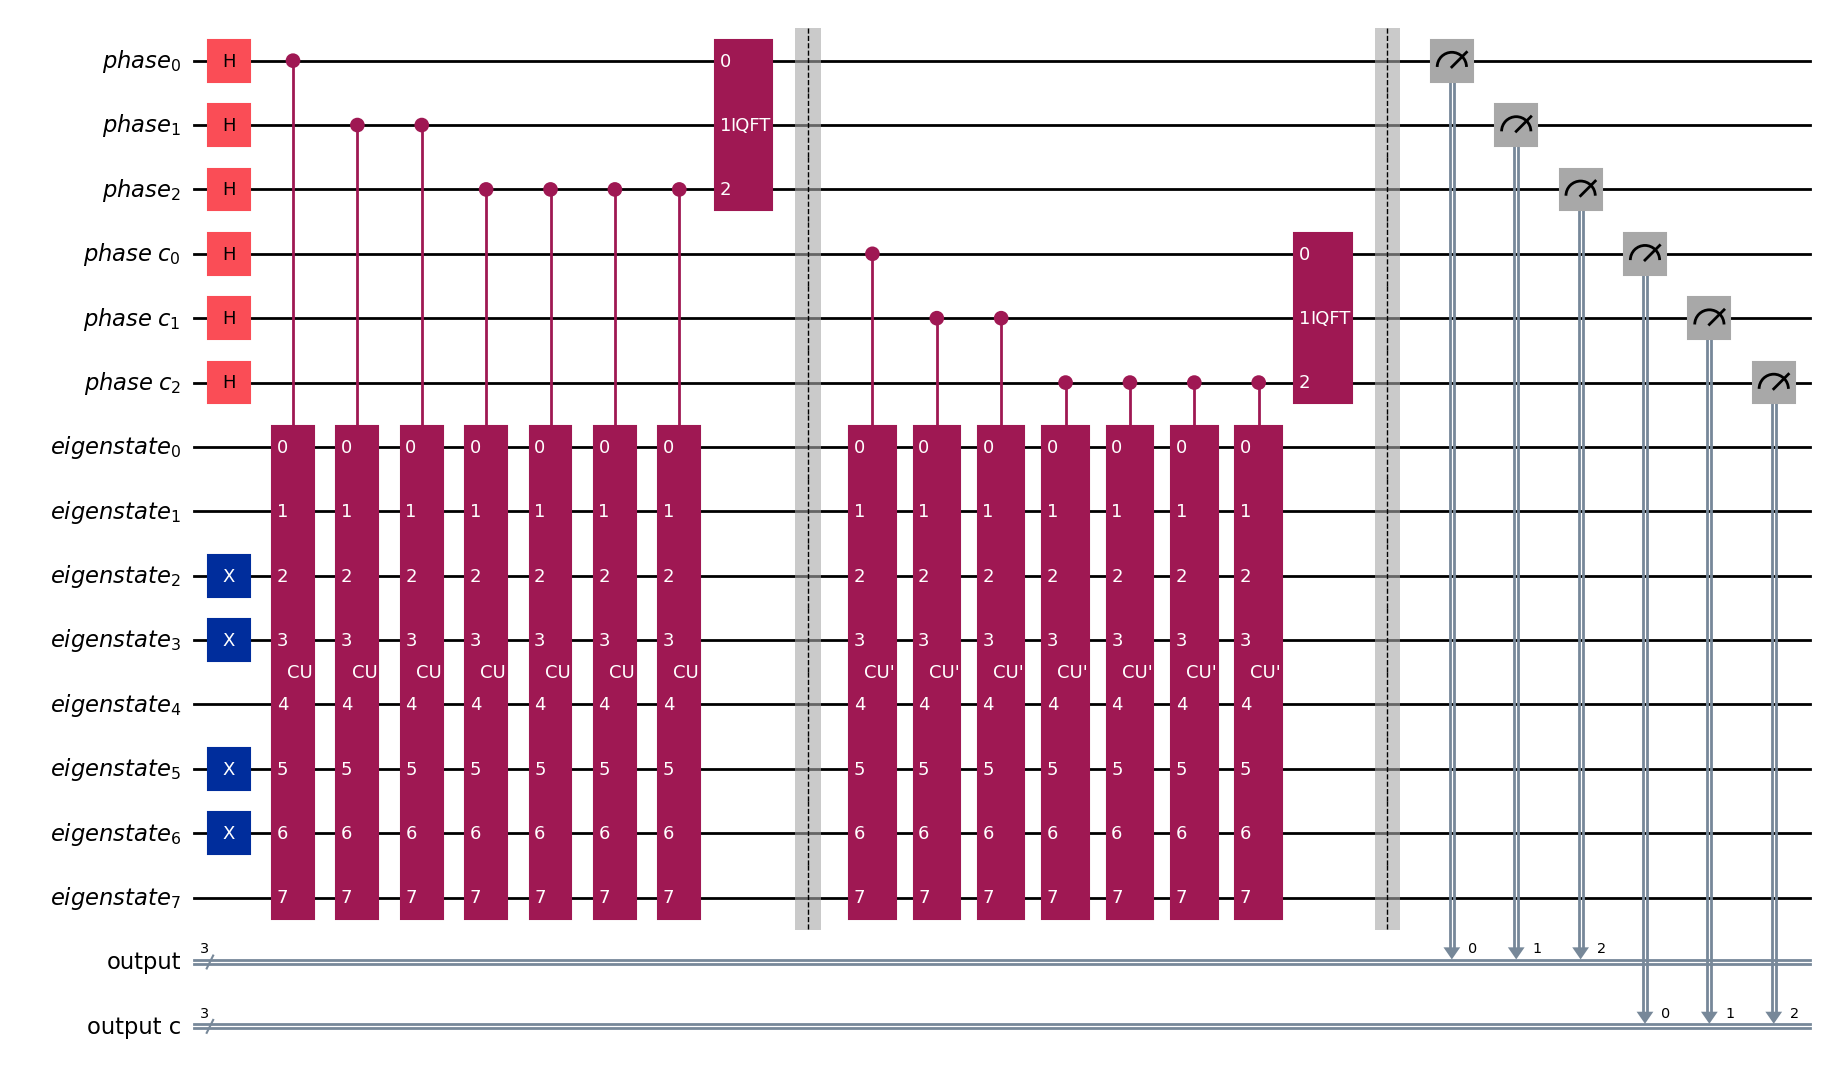

In [9]:
n = 3 ## number of estimation qubits.
## A->B->C->D->A
eig = eigstatelist[0]
eig = eig[::-1] # needs to be reversed (Qiskit convention)
qc1 = SingleHamiltonianCycle(eig, n)
qc1.draw(fold=-1, output='mpl')

In [10]:
simulator = Aer.get_backend('qasm_simulator')
qc1 = transpile(qc1, simulator)
result = simulator.run(qc1).result()
counts1 = result.get_counts(qc1)

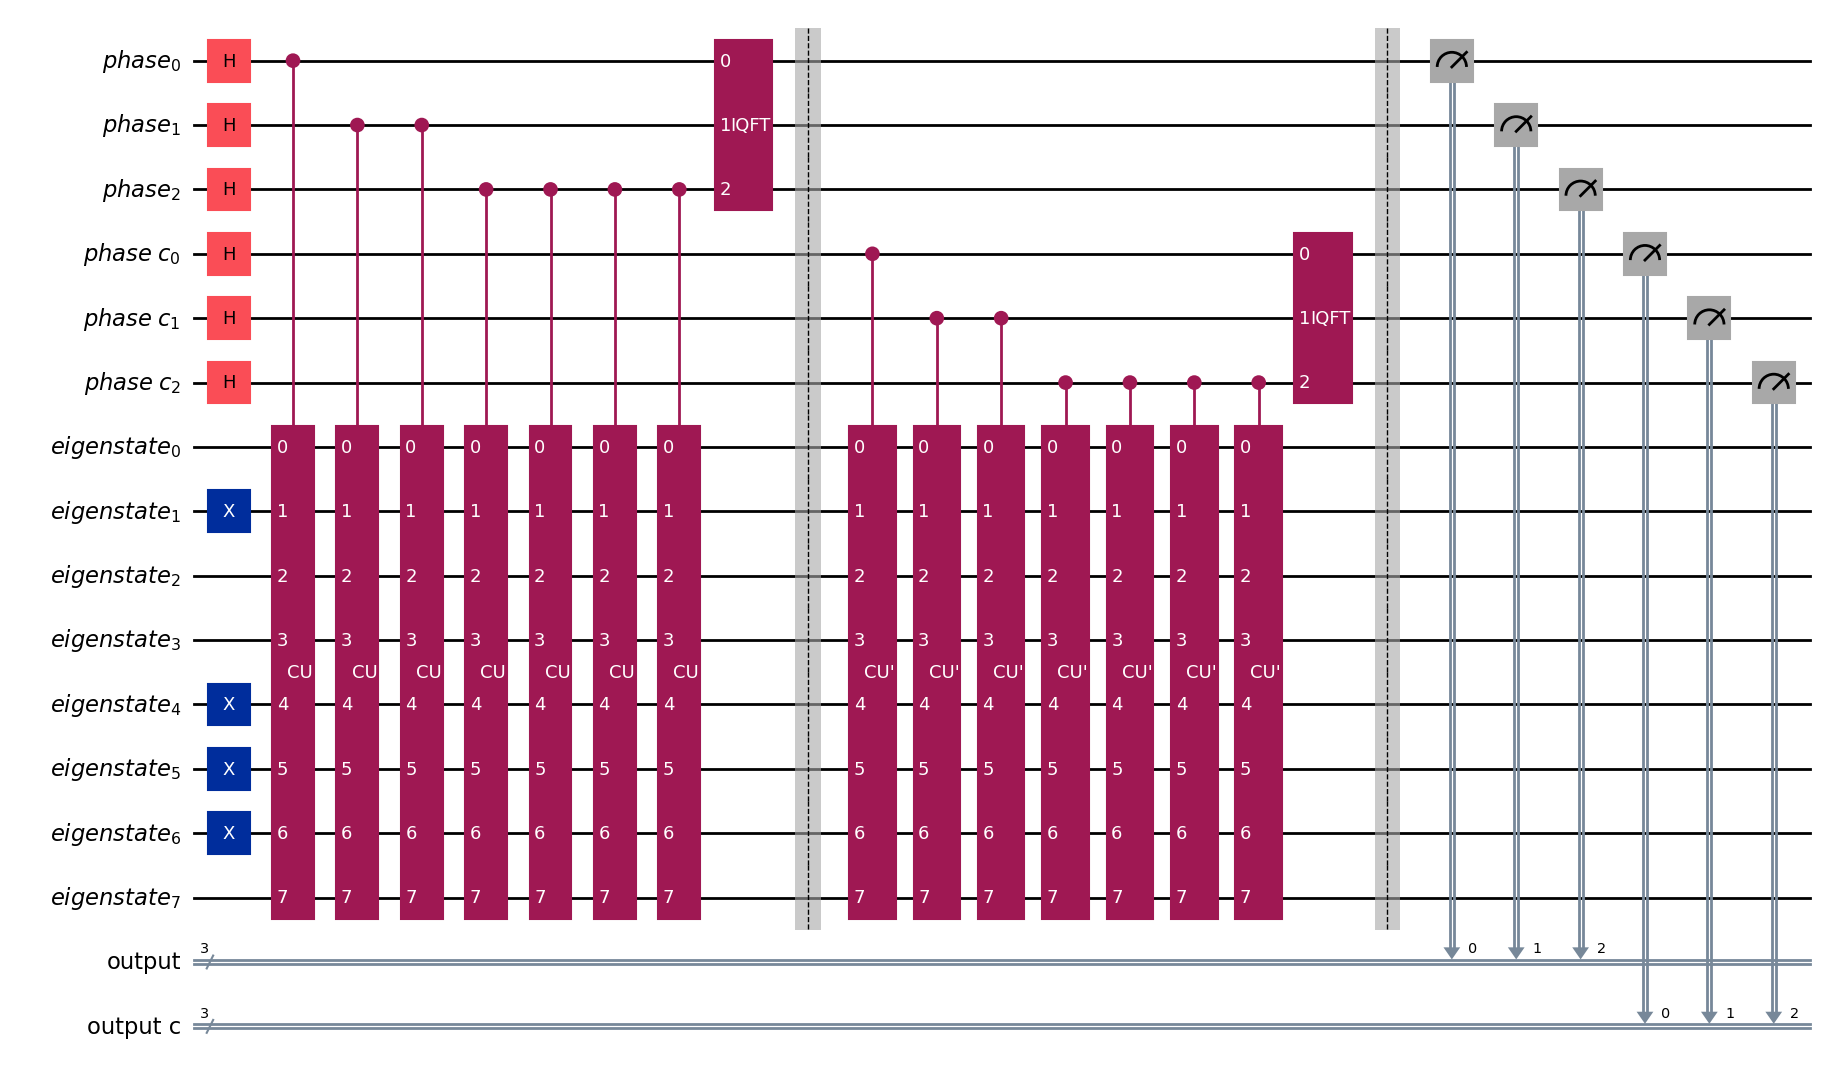

In [11]:
## A->B->D->C->A
eig = eigstatelist[1]
eig = eig[::-1] # needs to be reversed (Qiskit convention)
qc2 = SingleHamiltonianCycle(eig, n)
qc2.draw(fold=-1, output='mpl')

In [12]:
simulator = Aer.get_backend('qasm_simulator')
qc2 = transpile(qc2, simulator)
result = simulator.run(qc2).result()
counts2 = result.get_counts(qc2)

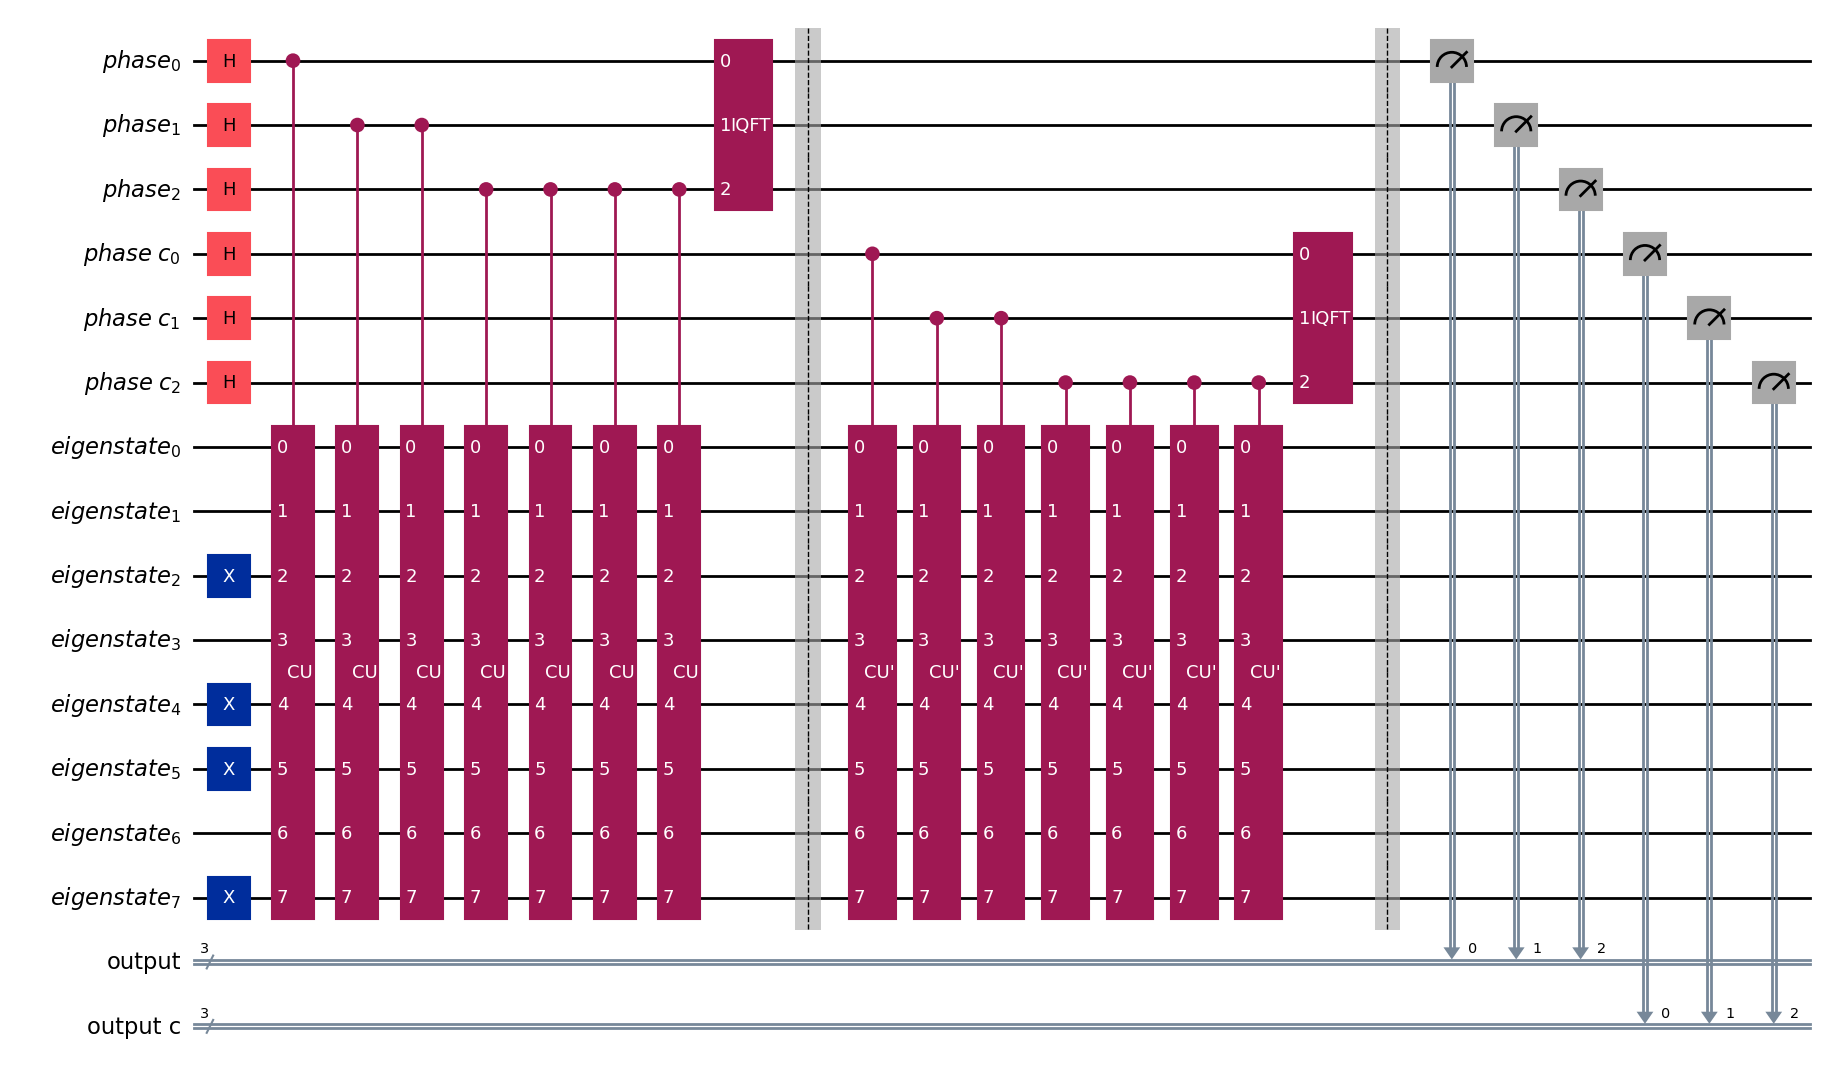

In [13]:
## A->C->B->D->A
eig = eigstatelist[2]
eig = eig[::-1] # needs to be reversed (Qiskit convention)
qc3 = SingleHamiltonianCycle(eig, n)
qc3.draw(fold=-1, output='mpl')

In [14]:
simulator = Aer.get_backend('qasm_simulator')
qc3 = transpile(qc3, simulator)
result = simulator.run(qc3).result()
counts3 = result.get_counts(qc3)

In [15]:
# quick check
# printing most probable values [before, after] constraint values removed
print(' before after')
print('cycle 1', bitstring_converter(max(counts1, key=counts1.get)))
print('cycle 2', bitstring_converter(max(counts2, key=counts2.get)))
print('cycle 3', bitstring_converter(max(counts3, key=counts3.get)))

 before after
cycle 1 [0.875, 0.875]
cycle 2 [0.875, 0.5]
cycle 3 [0.75, 0.5]


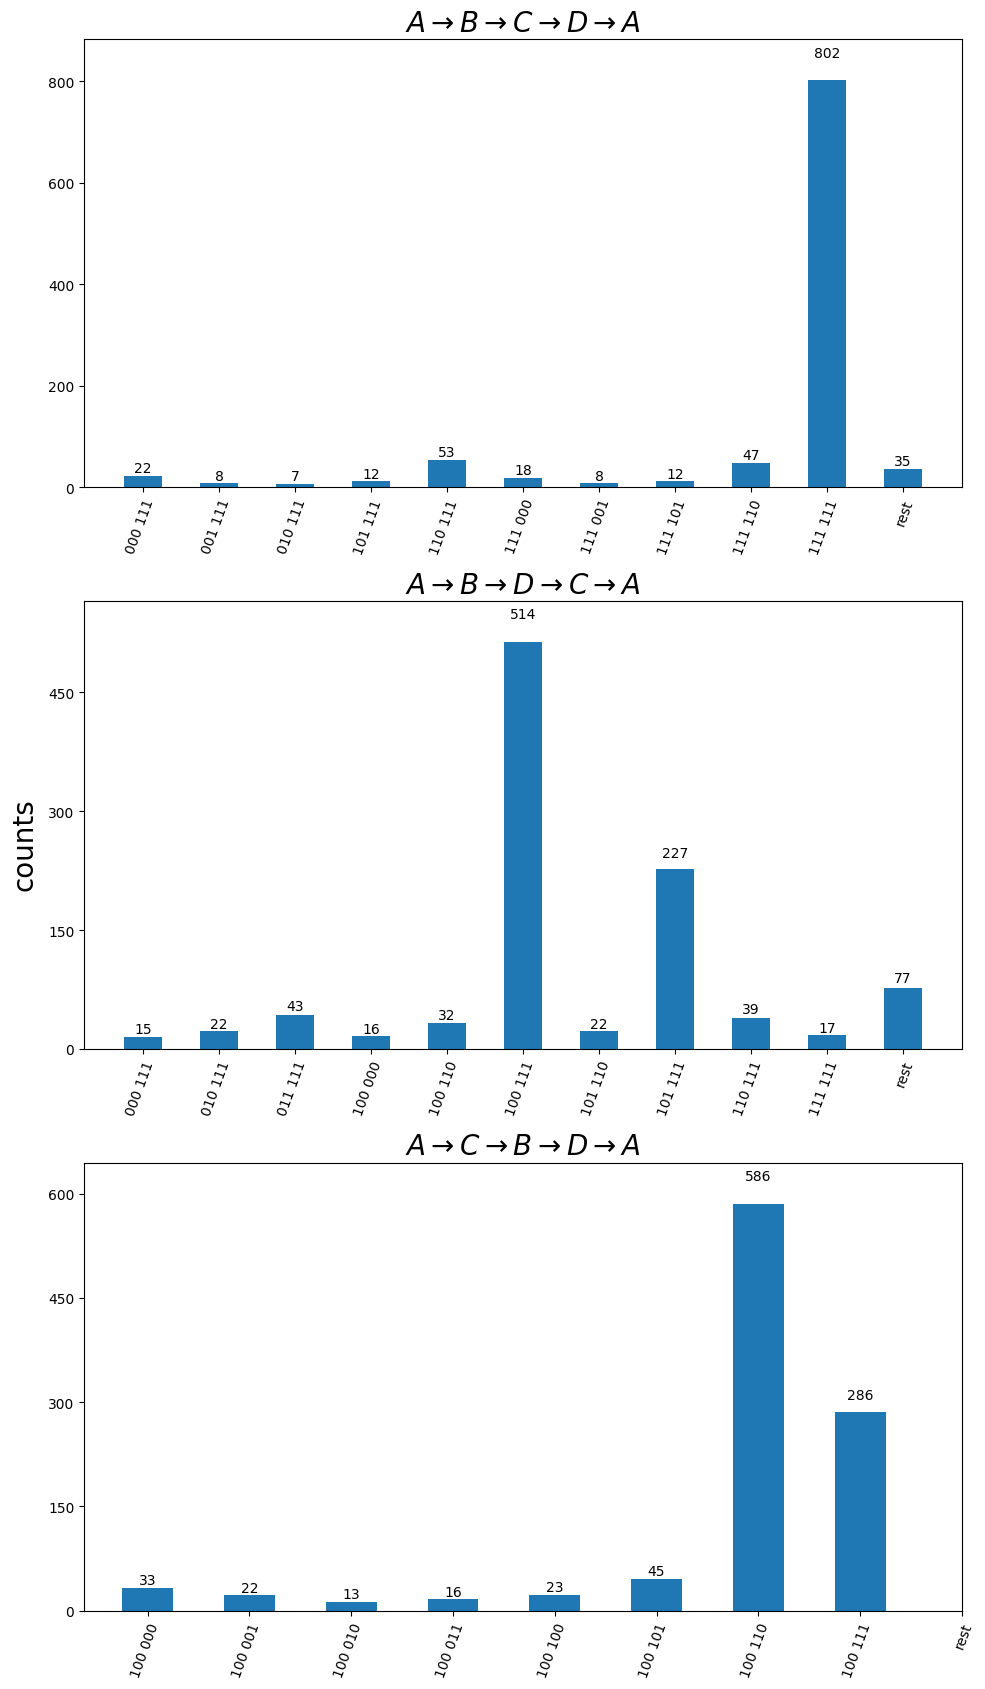

In [20]:
fig, ax = plt.subplots(3, 1, figsize=(10, 17))
fig.subplots_adjust(hspace=10)
fig.supylabel('counts', fontsize=20)
plot_histogram(counts1, number_to_keep = 10, ax= ax[0])
plot_histogram(counts2, number_to_keep = 10, ax = ax[1])
plot_histogram(counts3, number_to_keep = 10, ax = ax[2])
ax[0].set_title('$A \\rightarrow B \\rightarrow C \\rightarrow D \\rightarrow A$',fontsize = 20)
ax[1].set_title('$A \\rightarrow B \\rightarrow D \\rightarrow C \\rightarrow A$',fontsize = 20)
ax[2].set_title('$A \\rightarrow C \\rightarrow B \\rightarrow D \\rightarrow A$',fontsize = 20)
ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[2].grid(False)
plt.tight_layout()
plt.savefig('plots/'+ str(n) + 'qubit-4city_other.pdf')
plt.show()